In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import models
import cv2
import matplotlib.pyplot as plt

2024-12-17 21:09:09.799567: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-17 21:09:09.805002: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-17 21:09:09.819729: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734462549.844089   11085 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734462549.851017   11085 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 21:09:09.878226: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [12]:
# PUT YOUR IMAGE PATH HERE
image_path = "/home/georgs/Downloads/test4.jpg"
# PUT THE MODEL PATH HERE
model_path = "/home/georgs/Downloads/transformer_unet_ensemble.keras"

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


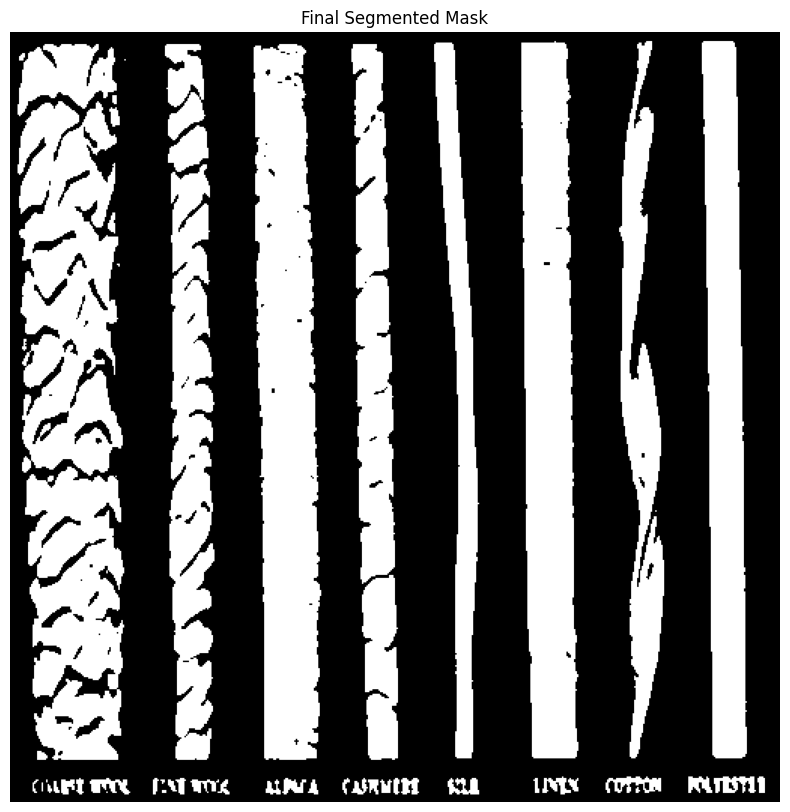

Segmented mask saved to segmented_result.png


In [13]:
# -------------------
# Configuration
# -------------------
IMG_HEIGHT = 512
IMG_WIDTH = 512
THRESHOLD = 0.5  # Threshold for binary mask
MIN_AREA = 8000  # Minimum connected component area for noise removal

# -------------------
# Helper Functions
# -------------------
def equalize_brightness(img):
    """Equalize brightness using CLAHE on the LAB color space."""
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(2, 2))
    l_eq = clahe.apply(l)
    lab_eq = cv2.merge((l_eq, a, b))
    return cv2.cvtColor(lab_eq, cv2.COLOR_LAB2BGR)

def erode_mask(binary_mask, kernel_size=(3, 3), iterations=2):
    """Apply erosion to binary mask."""
    kernel = np.ones(kernel_size, np.uint8)
    return cv2.erode(binary_mask, kernel, iterations=iterations)

def dilate_mask(binary_mask, kernel_size=(3, 3), iterations=2):
    """Apply dilation to binary mask."""
    kernel = np.ones(kernel_size, np.uint8)
    return cv2.dilate(binary_mask, kernel, iterations=iterations)

def remove_noise(binary_mask, min_area):
    """Remove small connected components."""
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)
    cleaned_mask = np.zeros_like(binary_mask)
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_area:
            cleaned_mask[labels == i] = 255
    return cleaned_mask

def check_black_pixel_ratio(binary_mask, threshold=0.7):
    """
    Check if the proportion of black pixels in a binary mask exceeds a threshold.
    :param binary_mask: Input binary mask (0s and 255s).
    :param threshold: Proportion threshold.
    :return: True if black pixel ratio exceeds threshold, False otherwise.
    """
    total_pixels = binary_mask.size
    black_pixels = np.sum(binary_mask == 0)
    black_ratio = black_pixels / total_pixels
    return black_ratio > threshold

# -------------------
# Load Model
# -------------------
model = models.load_model(model_path, compile=False)

# -------------------
# Load and Preprocess Single Image
# -------------------
original_img = cv2.imread(image_path, cv2.IMREAD_COLOR)
if original_img is None:
    raise ValueError(f"Could not read image from {image_path}")

# Save original dimensions for later resizing
orig_height, orig_width = original_img.shape[:2]

# Equalize brightness and resize to (512x512)
preprocessed_img = equalize_brightness(original_img)
preprocessed_img = cv2.resize(preprocessed_img, (IMG_WIDTH, IMG_HEIGHT))
preprocessed_img = preprocessed_img.astype(np.float32) / 255.0

# -------------------
# Prediction
# -------------------
prediction = model.predict(np.expand_dims(preprocessed_img, axis=0))[0]
pred_mask = (prediction[:, :, 0] > THRESHOLD).astype(np.uint8) * 255

# -------------------
# Post-processing
# -------------------
eroded_mask = erode_mask(pred_mask, kernel_size=(3, 3), iterations=3)
cleaned_mask = remove_noise(eroded_mask, MIN_AREA)
final_mask = dilate_mask(cleaned_mask, kernel_size=(3, 3), iterations=3)

# Check black pixel ratio and revert if needed
if check_black_pixel_ratio(final_mask, threshold=0.8):
    final_mask = pred_mask  # Revert to original prediction mask if too black

# -------------------
# Output Result
# -------------------
plt.figure(figsize=(10, 10))
plt.imshow(final_mask, cmap='gray')
plt.title('Final Segmented Mask')
plt.axis('off')
plt.show()

# Save the final mask to file
output_path = 'segmented_result.png'
cv2.imwrite(output_path, final_mask)
print(f"Segmented mask saved to {output_path}")
